<h1> Tâche 9 : Calcul des températures de Debye et d'Einstein du ScCuO2 ainsi que les chaleurs spécifiques et les densités d'états de phonons correspondantes </h1>

Dans ce notebook, nous calculerons les températures de Debye et d'Einstein du ScCuO2 tels que les modèles correspondants minimisent l'erreur au sens des moindres carrés sur l'ensemble de la courbe de la chaleur spécifique. Ensuite, nous représenterons 3 courbes de chaleur spécifique : celle de ScCuO2 telle que téléchargée, celle correspondant au modèle de Debye ainsi que celle correspondant au modèle d'Einstein. Enfin, nous représenterons les trois densités d'état de phonons correspondantes. 

In [3]:
import numpy as np
from scipy.constants import R, hbar, k
from scipy.optimize import curve_fit
from scipy.integrate import quad
import matplotlib.pyplot as plt

from mp_api.client import MPRester
from pymatgen.core.operations import SymmOp
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen.electronic_structure.plotter import BSPlotter
from pymatgen.phonon.plotter import PhononBSPlotter
from jupyter_jsmol.pymatgen import quick_view
from lmapr1492 import plot_brillouin_zone, get_plot_bs, get_plot_dos, get_plot_bs_and_dos, get_branch_wavevectors
from plotly.subplots import make_subplots
import plotly.graph_objects as go



In [4]:
mp_key = "emUreNDiEdgEatR8YwlD3hfzF9Onx8tt"
mp_id = "mp-4636"

In [5]:
with MPRester(mp_key) as m:
    structure = m.get_structure_by_material_id(mp_id)
    el_dos = m.get_dos_by_material_id(mp_id)
    ph_dos = m.get_phonon_dos_by_material_id(mp_id)
    ph_bs = m.get_phonon_bandstructure_by_material_id(mp_id)

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving ElectronicStructureDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving PhononBSDOSDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving PhononBSDOSDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

<h2> Calcul des températures de Debye et d'Einstein </h2>

Pour déterminer les températures caractéristiques de Debye ($\theta_D$) et d'Einstein ($\theta_E$), on va utiliser les données expérimentales de la chaleur spécifique phononique du matériau étudié (ici ScCuO2). Ces températures sont obenues en minimisant l'erreur entre la chaleur spécifique théorique, fournie par les modèles de Debye et d'Einstein, et les données calculées à partir de la densité d'états phononique.

<h3> Modèle de Debye </h3>

Le modèle de Debye fait l'hypothèse que toutes les fréquences $\omega_{\sigma}(\textbf{q})$ ont la même dispersion linéaire : $\omega_{\sigma}(\textbf{q}) = vq$. On définit également la fréquence de Debye $\omega_D = vq_D$ ainsi que la temérature de Debye par $k_b\theta_D = \hbar\omega_D = \hbar vq_D)$.  La température de Debye ($\theta_D$) est déterminée en ajustant l'expression de la chaleur spécifique, obtenue à partir d'une intégrale qui ne peut pas être résolue analytiquement : 

$ C_v = \frac{\Omega}{2\pi^2}3N_{at}R \int_{0}^{q_d} \frac{\beta^2\hbar^2v^2q^2e^{\beta\hbar vq}}{(e^{\beta\hbar vq}-1)^2}q^2\, dq$

Cette intégrale est calculée numériquement, et la température $\theta_D$ est ensuite ajustée en minimisant l'écart entre la courbe théorique et les données expérimentales en utilisant la fonctio curve_fit.

<h3> Modèle d'Einstein </h3>

Le modèle d'Einstein repose sur l'hypothèse que tous les atomes du réseau vibrent à une même fréquence naturelle de vibration ($\omega_E$). La température d'Einstein $\theta_E$ est définie par $k_b\Theta_E = \hbar\omega_E$ et permet d'exprimer la chaleur spécifique molaire. Pour le modèle d'Einstein, la chaleur spécifique est exprimée comme : 

$C_v = 3N_{at}R (\frac{\hbar\omega_E}{k_bT})^2 \frac{e^{\frac{\hbar\omega_E}{k_bT}}}{(e^{\frac{\hbar\omega_E}{k_bT}}-1)^2}$


Pour ajuster cette expression théorique aux données expérimentales, on utilise une méthode de régression non linéaire (curve_fit) pour estimer la valeur de $\theta_E$ qui minimise l'écart avec les données mesurées. 

In [6]:
#nombre d'atomes dans la cellule primitive
N_at = len(structure)

temperatures = np.arange (5, 1000, 5)

ph_cv = np.array([ph_dos.cv(T) for T in temperatures]) / (3*N_at*R)

def Cv_Debye(T, theta_D):
    def integrand(x):
        return(x**4*np.exp(x))/ (np.exp(x)-1)**2
    
    Cv_vals = []
    for temp in T:
        x_D = theta_D/temp
        integral, _ = quad(integrand, 0, x_D)
        Cv = 3*(temp/theta_D)**3*integral
        Cv_vals.append(Cv)
    return np.array(Cv_vals)

theta_D_opt, _ = curve_fit(lambda T, theta_D : Cv_Debye(T, theta_D), temperatures, ph_cv)
print(f"Température de Debye estimée : {theta_D_opt[0]:.2f} K")

def Cv_Einstein(T, theta_E) : 
    x = theta_E /T
    return x**2*np.exp(x)/(np.exp(x)-1)**2

theta_E_opt, _ = curve_fit(Cv_Einstein, temperatures, ph_cv)
print(f"Température d'Einstein estimée : {theta_E_opt[0]:.2f} K")

Température de Debye estimée : 598.10 K
Température d'Einstein estimée : 441.04 K


<h2> Chaleur spécifique </h2>

Avec les températures de Debye et d'Einstein déterminée ci-dessus, nous allons maintenant pouvoir comparer les courbes de la chaleur spécifique obtenues pour ces températures ainsi que celle obtenue grâce à la densité d'état. 

<h3> Modèle de Debye </h3>

Pour $T >> \theta_D : C_v -> 3N_{at}R$

Pour $T << \theta_D : C_v \propto T^3$

<h3> Modèle d'Einstein </h3>

Pour $T >> \theta_E : C_v -> 3N_{at}R$

Pour $T << \theta_E : C_v \propto e^{\frac{-\theta_E}{T}}$

Le graphique ci-dessous représente : 

- En rose, la chaleur spécifique qui a été calculée à partir des données du matériau 
- En bleu, la chaleur spécifique calculée grâce au modèle d'Einstein
- En orange, la chaleur spécifique calculée grâce au modèle de Debye

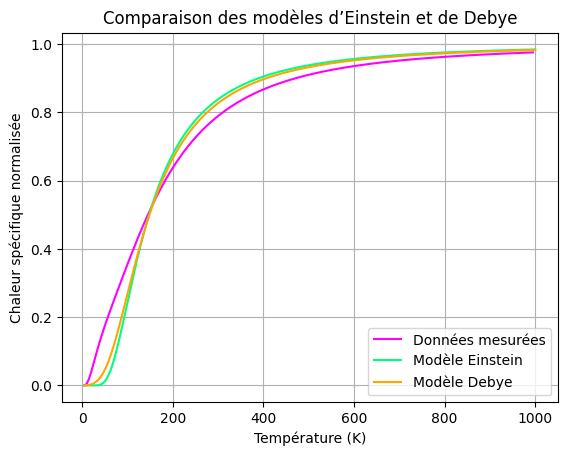

In [7]:
T_plot = np.linspace(5, 1000, 500)

x_E = theta_E_opt / T_plot
cv_E = (x_E**2 * np.exp(x_E)) / (np.exp(x_E) - 1)**2

cv_D = []
for t in T_plot:
    I, _ = quad(lambda x: (x**4 * np.exp(x)) / (np.exp(x) - 1)**2, 0, theta_D_opt / t)
    cv_D.append(3 * (t / theta_D_opt)**3 * I)
cv_D = np.array(cv_D)


plt.plot(temperatures, ph_cv, 'fuchsia', label='Données mesurées')
plt.plot(T_plot, cv_E, 'springgreen', label='Modèle Einstein')
plt.plot(T_plot, cv_D, 'orange', label='Modèle Debye')
plt.xlabel("Température (K)")
plt.ylabel("Chaleur spécifique normalisée")
plt.legend()
plt.title("Comparaison des modèles d’Einstein et de Debye")
plt.grid()
plt.show()

<h2> Densité d'état des phonons </h2>

Ensuite, nous allons représenter les trois densités d'état des phonons correspondantes, celles associées aux modèles d'Einstein et de Debye ainsi que celle correspondant au ScCuO2 (et basée sur les données téléchargées). La densité de modes normaux par cellule unité ($g(\omega)$)est une manière plus "pratique" d'écrire les propriétés du réseau. Pour cela, on utilise une intégrale en fréquence définie de telle sorte que $g(\omega)d\omega$ soit le nombre total de modes normaux dont la fréquence est comprise entre $\omega$ et $\omega + d\omega$ divisée par le volume de la cellule unité. La densité de modes normaux ou la densité d'état des phonons, est normalisée de telle sorte que : 

$\int{g(\omega)d\omega} = 3N_{at}$ 

<h3> Modèle d'Einstein </h3>

Pour le modèle d'Einstein, $g(\omega)$ est un delta de Dirac piqué en $\omega_E$ :

$g_E(\omega) = 3N_{at}\delta(\omega-\omega_E)$

<h3> Modèle de Debye </h3>

Pour le modèle de Debye $g(\omega)$ est une fonction parabolique de la fréquence. 

$g_D(\omega) = \frac{3N_{at}\Omega}{(2\pi)^3} \int_{q<q_D} \delta(\omega - vq)\, dq$
$ = \frac{3N_{at}\Omega}{2\pi^2} \int_0^{q_D} \delta(\omega - vq)q^2\, dq$

Lorsque $\omega < \omega_D = vq_D$,  $g_D(\omega) = \frac{3N_{at}\Omega}{2\pi^2} \frac{\omega^2}{v^3}$

Lorsque $\omega > \omega_D$,  $g_D(\omega) = 0$

Le graphique ci-dessous représente : 

- En rose, la densité d'états de phonons réelles qui est obtenue par simulation
- En bleu, la densité d'états de phonons telle que représentée par le modèle d'Einstein
- En orange, la densité d'états de phonons telle que représentée par le modèle de Debye

Fréquence d’Einstein (THz) : 9.189836042094344
Fréquence de Debye (THz) : 12.46237857267543


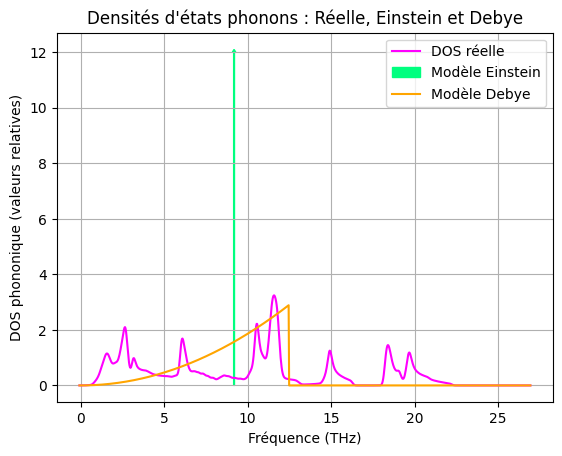

In [9]:
theta_E = theta_E_opt.item()
theta_D = theta_D_opt.item()

frequencies = ph_dos.frequencies      # Fréquences [THz]
density_ref = ph_dos.densities        # Densité d'états phonons
plt.plot(frequencies, density_ref, label="DOS réelle", color='fuchsia')

omega_E = (k * theta_E) / (hbar * 2 * np.pi)      # En Hz
omega_E_THz = omega_E * 1e-12                       # En THz
print("Fréquence d’Einstein (THz) :", omega_E_THz)

plt.arrow(omega_E_THz, 0, 0, 3 * N_at, width=0.05, head_width=0.2, head_length=0.1, fc='springgreen', ec='springgreen', label='Modèle Einstein')

omega_D = (k * theta_D) / (hbar * 2 * np.pi) * 1e-12  # En THz
print("Fréquence de Debye (THz) :", omega_D)

volume_uc = structure.volume


q_D = (6 * np.pi**2 / volume_uc)**(1/3)

density_debye = np.zeros_like(frequencies)
for i, f in enumerate(frequencies):
    if f < omega_D:
        density_debye[i] = (3 * N_at * volume_uc * f**2 * q_D**3) / (2 * np.pi**2 * omega_D**3)
    else:
        density_debye[i] = 0


plt.plot(frequencies, density_debye, label='Modèle Debye', color='orange')


plt.title("Densités d'états phonons : Réelle, Einstein et Debye")
plt.xlabel("Fréquence (THz)")
plt.ylabel("DOS phononique (valeurs relatives)")
plt.legend()
plt.grid(True)
plt.show()